### Cost Function 
1. Mean Square Error : 평균제곱오차, 예측값과 실제값의 차이를 제곱함  
2. Cross Entropy : 예측값과 실제의 차가 클수록 기하급수적으로 비용을 증가시킴 (MSE 대비 더 크게 증가)

In [1]:
import numpy as np

# MSE 
def squared_error(y, yhat): 
    return (y - yhat)**2

In [2]:
squared_error(1, 1), squared_error(1, 0.9), squared_error(1, 0.6), squared_error(1, 0.1)

(0, 0.009999999999999995, 0.16000000000000003, 0.81)

In [3]:
from numpy import log
# Cross Entropy
def cross_entropy(y, a):
    return -1*(y*log(a) + (1-y)*log(1-a))

In [4]:
cross_entropy(1, 0.9997), cross_entropy(1, 0.9), cross_entropy(1, 0.6), cross_entropy(1, 0.1)

(0.00030004500900199243,
 0.10536051565782628,
 0.5108256237659907,
 2.3025850929940455)

---

## 중간 층에서 학습 측정하기
- MNIST 숫자를 분류하는 간단한 완전 연결 신경망을 만들고 모델의 여러 은닉층에서 학습 속도를 조사

In [5]:
import numpy as np
np.random.seed(42)

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # new!
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

/var/folders/26/vn1wz2xd3mj9r0sjzy_cj1jc0000gn/T/ipykernel_47624/3540206342.py:11: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


### 사용자 정의 콜백을 정의합니다.
- 이 콜백은 에포크가 끝날 때마다 가중치를 구해 그레이디언트로 변환합니다. 
- 이 그레이디언트는 딕셔너리에 저장되고 훈련이 종료될 때 에포크마다 각 층에서 얼마나 훈련이 빠르게 진행됐는지 측정하기 위해 유클리드 노름(Euclidean norm)을 계산합니다.

In [6]:
class GradHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        # 은닉층의 목록을 만듭니다.
        self.layers = [layer for layer in self.model.layers if 'hidden_' in layer.name]
        
        # 빈 리스트로 그레이디언트 딕셔너리를 만듭니다.
        self.grads = {layer.name:[] for layer in self.layers}
        
        # 모델에서 초기 가중치를 가져옵니다.
        self.prev_w = [layer.get_weights()[0] for layer in self.layers]

    def on_epoch_end(self, batch, logs={}):
        # 에포크가 종료할 때 가중치를 얻습니다.
        curr_w = [layer.get_weights()[0] for layer in self.layers]
        
        # 학습률을 얻습니다.
        #lr = K.get_value(self.model.optimizer.lr)
        lr = K.get_value(self.model.optimizer.learning_rate)

        
        # 이전 가중치와 현재 가중치를 그레이디언트로 변환합니다.
        grads_ = [(prev - curr) for curr, prev in zip(curr_w, self.prev_w)]
        
        # 그레이디언트를 딕셔너리에 저장합니다.
        for i,layer in enumerate(grads_):
            self.grads[self.layers[i].name].append(layer)
        self.prev_w = curr_w
    
    def on_train_end(self, logs={}):
        # 훈련이 끝나면 에포크마다 각 층의 그레이디언트의 배열의 유클리드 노름을 계산합니다.
        self.norms = {k:[np.sqrt(np.sum([x*x for x in epoch])) for epoch in v] for k,v in self.grads.items()}

In [7]:
# 데이터 적재 및 전처리 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

X_train /= 255
X_test /= 255

n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [8]:
# 신경망 생성 
def build_model(hidden = 2):
    
    model = Sequential()
    model.add(Dense(30, activation='sigmoid', input_shape=(784,),name='input'))
    
    for h in range(hidden):
        model.add(Dense(30, activation='sigmoid',name='hidden_{}'.format(h)))
    
    model.add(Dense(10, activation='softmax'))
    
    return model

In [9]:
# build_model() 함수를 호출한 다음 모델을 컴파일하고 훈련하여 (그레이디언트가 저장된) history 객체를 반환합니다.
def build_and_train(hidden = 1, epochs=200):
    
    model = build_model(hidden)
    history = GradHistory()
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train[:1000], y_train[:1000], batch_size=32, epochs=epochs, verbose=1, callbacks=[history])

    
    return history

In [10]:
# 모델을 만들고 훈련하기 위해 이 메서드를 호출하면 `history` 객체가 반환됩니다.
# 5개의 은닉층과 200번의 에포크를 사용합니다.
norms_5 = build_and_train(5, 200)

/Users/yb_choi/Downloads/yes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-09 01:55:47.589329: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-09 01:55:47.589350: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-09 01:55:47.589354: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-09 01:55:47.589370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-09 01:55:47.589379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

Epoch 1/200


2025-06-09 01:55:47.825839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0883 - loss: 2.4846
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1121 - loss: 2.3608
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0992 - loss: 2.3421
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0993 - loss: 2.3161
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0856 - loss: 2.3027
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1147 - loss: 2.3063
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1070 - loss: 2.3008
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1117 - loss: 2.2977
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1365 - loss: 2.2963
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1272 - loss: 2.2968
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1177 - loss: 2.3029
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1189 - l

In [11]:
# 차트 출력 함수 
def plot(history, hidden, log=False):   
    fig = plt.figure(figsize=(8,6),dpi=300)
    
    layers = [layer for layer in history.norms.keys()]
    values = [history.norms[layer] for layer in layers]
    
    for layer,values in zip(layers[::-1],values[::-1]):
        ys = np.array(values[:])
        xs = np.array(range(ys.shape[0]))
        ys_smooth = gaussian_filter1d(ys, sigma=3)
        plt.plot(xs, ys_smooth, label=layer)
        
    plt.title('Learning speed with {} hidden layers'.format(hidden))
    plt.ylabel('Learning speed')
    if log:
        plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

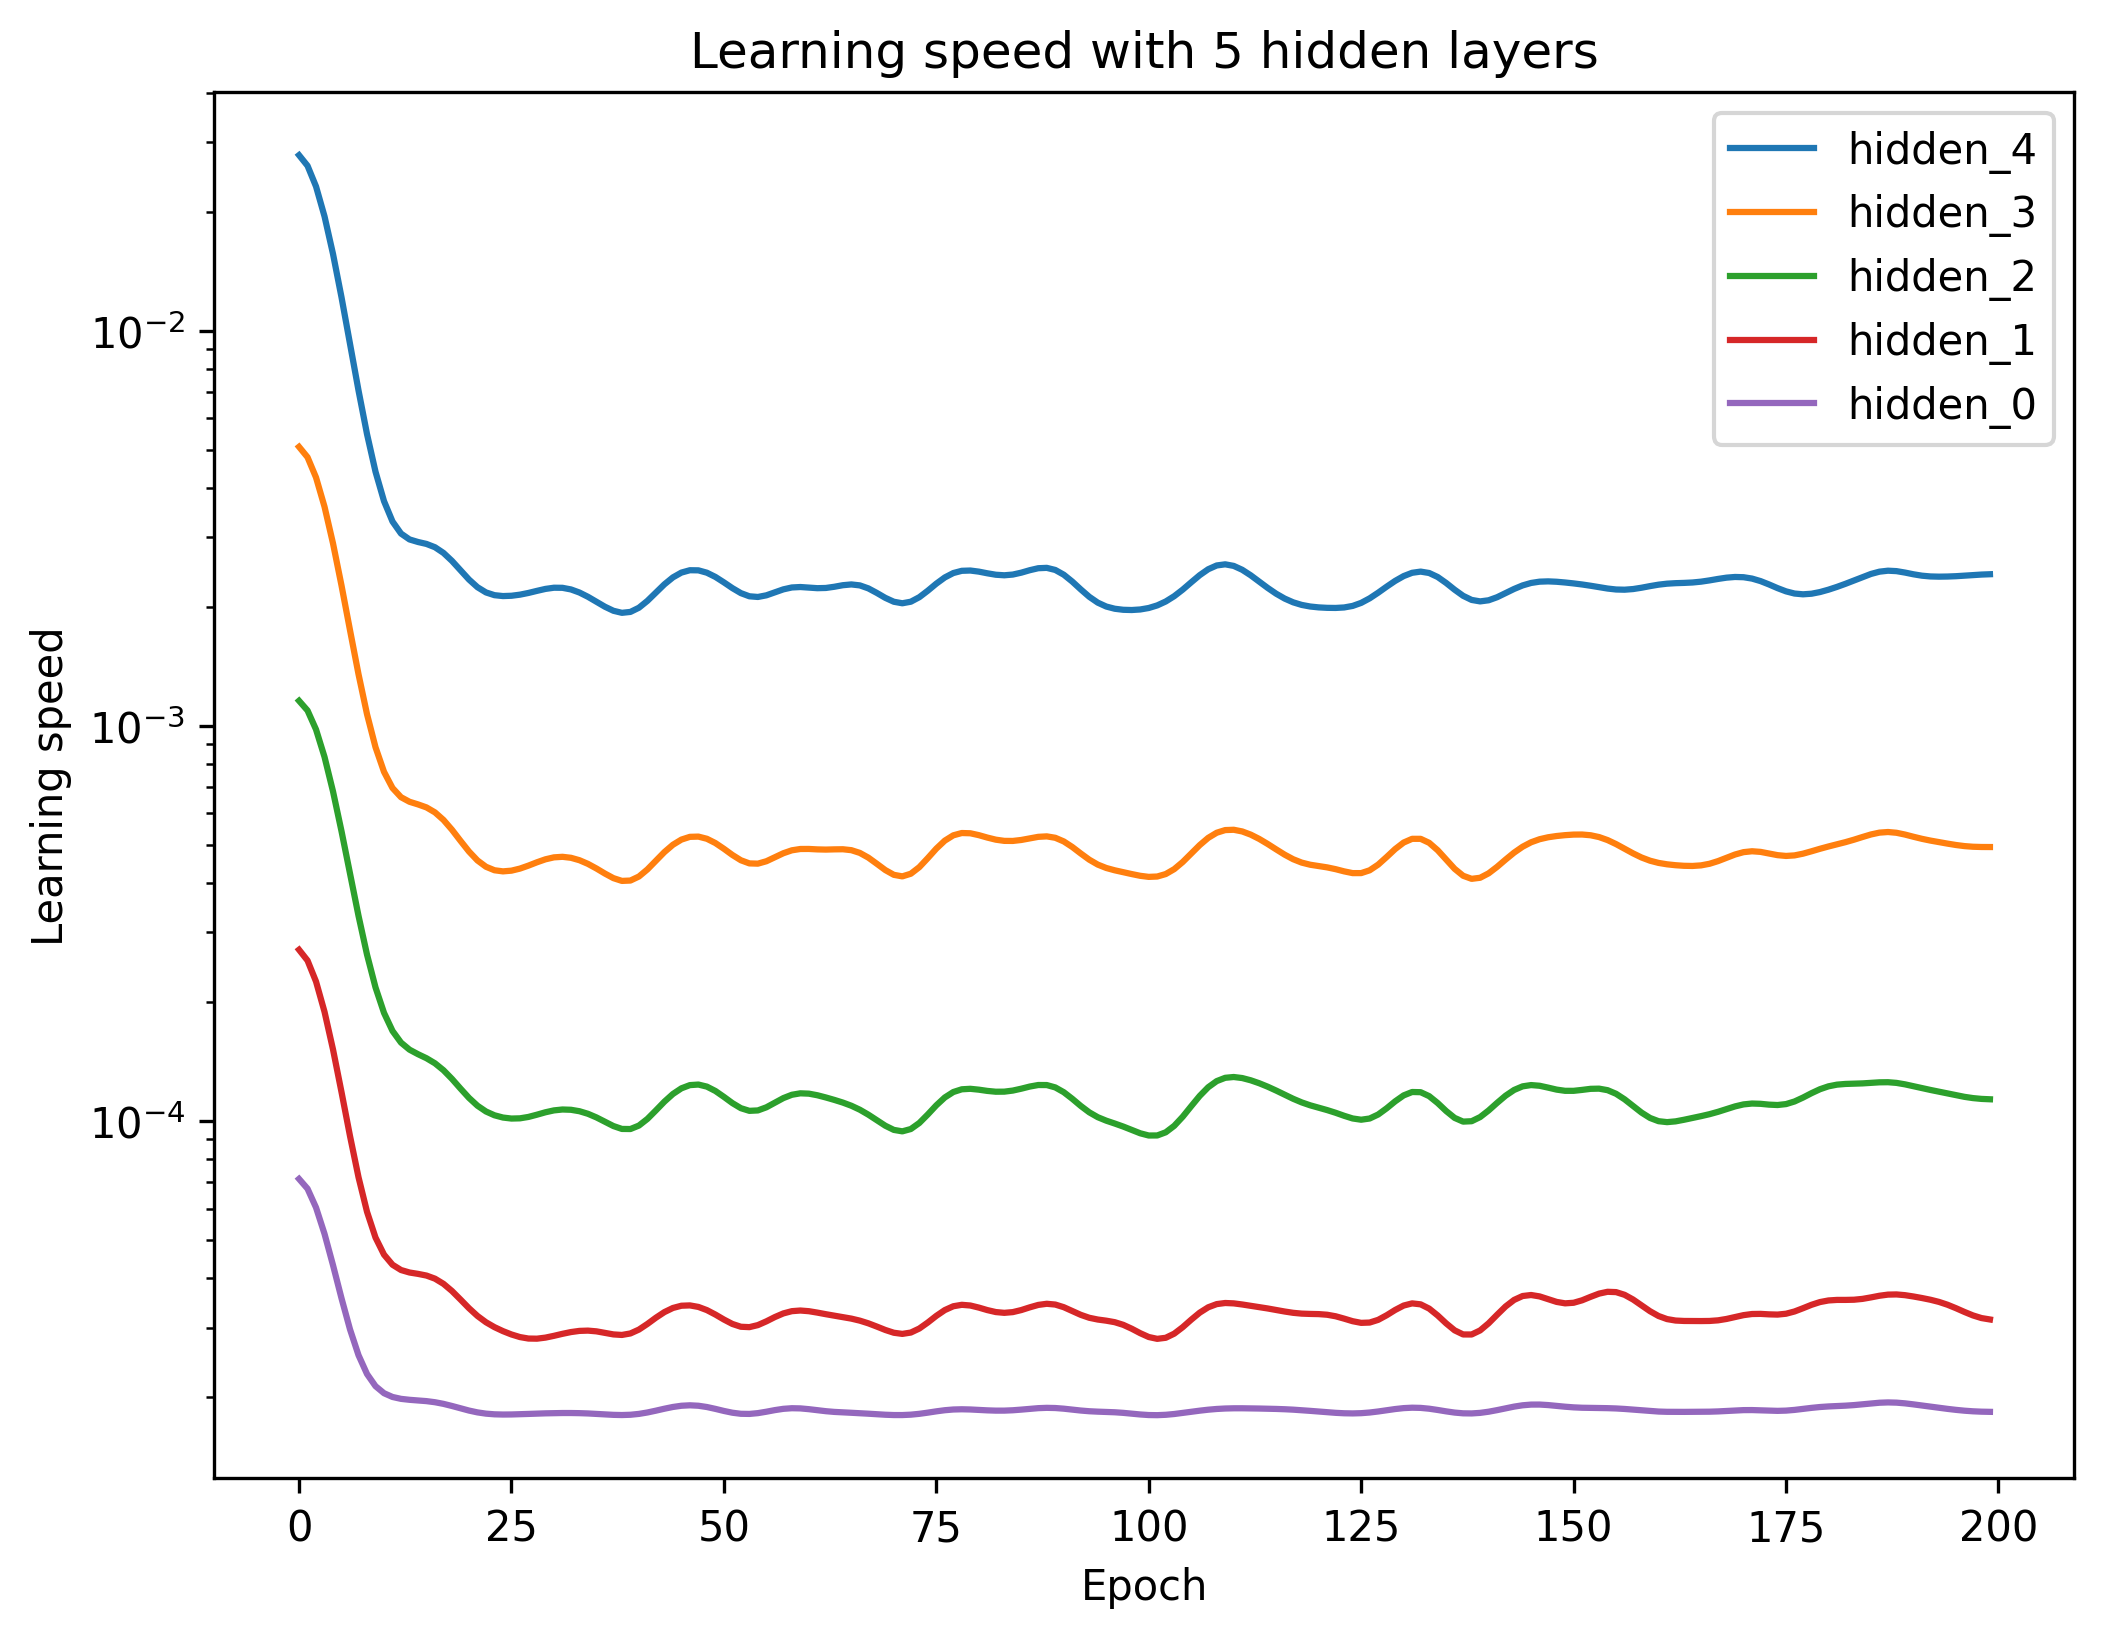

In [12]:
plot(norms_5, 5, True)